In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
import random

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(style="darkgrid", font_scale=1.2)
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from keras.models import Sequential
from keras.layers import Dense

<function matplotlib.pyplot.show>

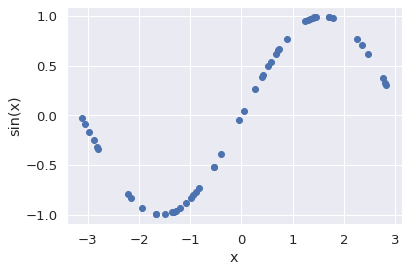

In [2]:
def sin_func(x):
  y = np.sin(x)
  return y

n = 50
x = np.random.uniform(-np.pi,np.pi, size=(n))
y = sin_func(x)
plt.xlabel('x')
plt.ylabel('sin(x)')
plt.scatter(x, y)
plt.show

In [3]:
# discriminator model
def discriminator_(n_inputs=2):
  model = Sequential()
  model.add(Dense(35, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
  model.add(Dense(1, activation='sigmoid'))
  # compile model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [4]:
# generator model
def generator_(latent_dim, n_outputs=2):
  model = Sequential()
  model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
  model.add(Dense(n_outputs, activation='linear'))
  return model

In [5]:
# gan model
def gan_(generator, discriminator):
  # make weights in the discriminator not trainable
  discriminator.trainable = False
  model = Sequential()
  # add generator and discriminator
  model.add(generator)
  model.add(discriminator)
  # compile model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [6]:
# sin function
def sin_func(x):
  y = np.sin(x)
  return y

# generate n real samples with labels
def generate_real_samples(n):
  x1 = np.random.uniform(-np.pi, np.pi, size=n)
  x2 = sin_func(x1)
  # stack arrays
  x1 = x1.reshape(n, 1)
  x2 = x2.reshape(n, 1)
  x = np.hstack((x1, x2))
  # generate class labels
  y = np.ones((n, 1))
  return x, y

# generate n fake samples with labels
def generate_fake_samples(generator, latent_dim, n):
  # generate points in latent space
  x_input = generate_latent_points(latent_dim, n)
  # predict outputs
  x = generator.predict(x_input)
  # create class labels
  y = np.zeros((n, 1))
  return x, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
  # generate points in the latent space
  x_input = np.random.randn(latent_dim * n)
  # reshape into a batch of inputs for the network
  x_input = x_input.reshape(n, latent_dim)
  return x_input

In [7]:
# function to calculate root mean square error (RMSE)
def calculate_err(output, input, overall):
  output = np.sum(output)
  input = np.sum(input)
  rmse = np.sqrt(np.multiply((1/overall), (output - input)**2))
  return rmse

def plot_loss(epoch, d_loss, g_loss, type_):
  plt.plot(range(epoch), d_loss, color='red', label='D Loss')
  plt.plot(range(epoch), g_loss, color='blue', label='G Loss')
  plt.legend()
  plt.xlabel('# Epochs')
  plt.ylabel('Loss')
  if type_ is 'R':
    title = 'Discriminator and Generator Loss (Real)'
  elif type_ is 'F':
    title = 'Discriminator and Generator Loss (Fake)'
  plt.title(title)
  plt.show()

1000 0.550000011920929 0.5699999928474426
RMSE: 1.6138321558788473


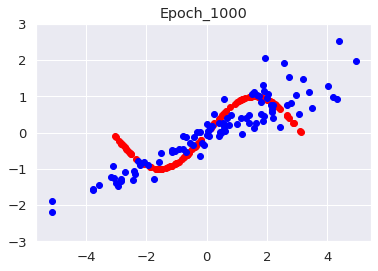

2000 0.38999998569488525 0.8299999833106995
RMSE: 0.996824407406623


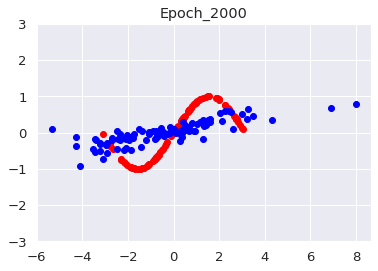

3000 0.30000001192092896 0.5699999928474426
RMSE: 0.6949152903181988


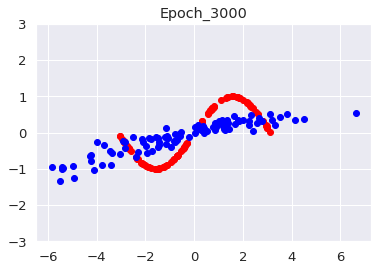

4000 0.3400000035762787 0.7799999713897705
RMSE: 0.3662127259894382


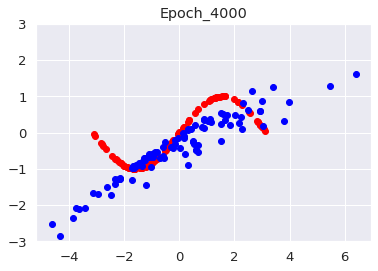

5000 0.46000000834465027 0.550000011920929
RMSE: 0.004897021167219119


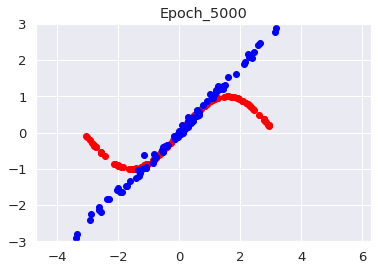

6000 0.7300000190734863 0.5400000214576721
RMSE: 0.32907212748191267


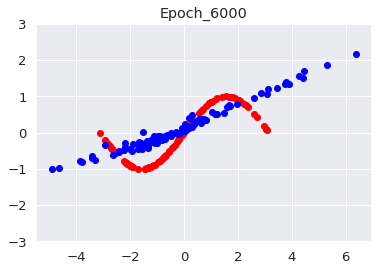

7000 0.6299999952316284 0.4399999976158142
RMSE: 0.5813335738550626


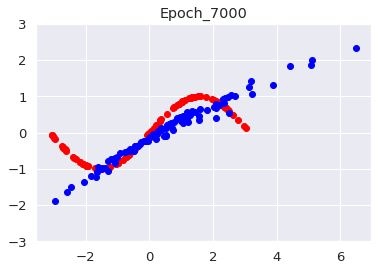

8000 0.6800000071525574 0.7300000190734863
RMSE: 0.24789918069148534


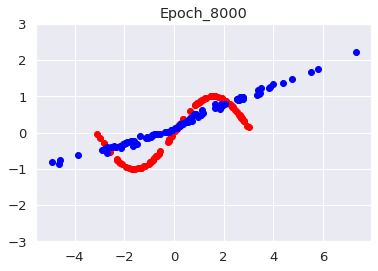

9000 0.5600000023841858 0.5400000214576721
RMSE: 0.17626855211952408


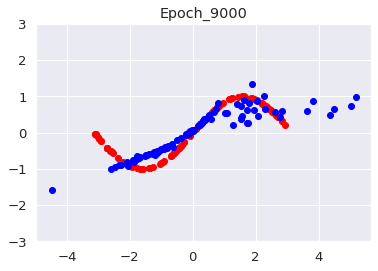

10000 0.38999998569488525 0.4300000071525574
RMSE: 0.14191501064218237


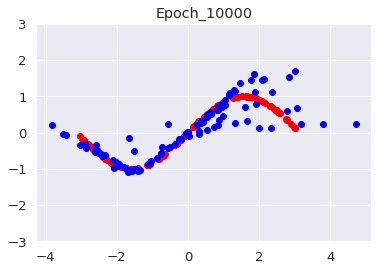

In [8]:
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
  # prepare and evaluate real samples 
  x_real, y_real = generate_real_samples(n)
  loss_real, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
  # prepare and evaluate fake examples
  x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
  loss_fake, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
  # summarize discriminator performance
  print(str(epoch + 1), acc_real, acc_fake)
  print("RMSE:", calculate_err(x_real, x_fake, epoch+1))
  # scatter plot real and fake data points
  title = "Epoch_" + str(epoch + 1)
  plt.scatter(x_real[:, 0], x_real[:, 1], color='red')
  plt.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
  plt.title(title)
  plt.ylim(-3.0, 3.0)
  plt.show()

# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=1000):
  gen_loss = []
  dis_loss = []
  # determine half the size of one batch, for updating the discriminator
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
    # prepare real and fake samples
    x_real, y_real = generate_real_samples(half_batch)    
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
    # update discriminator
    loss_real = d_model.train_on_batch(x_real, y_real)
    loss_fake = d_model.train_on_batch(x_fake, y_fake)
    d_loss = 0.5 * np.add(loss_real, loss_fake)
    dis_loss.append(d_loss)
    # print(i, d_loss)
    # prepare points in latent space as input for the generator
    x_gan = generate_latent_points(latent_dim, n_batch)
    # create inverted labels for the fake samples
    y_gan = np.ones((n_batch, 1))
    # update the generator via the discriminator's error
    g_loss = gan_model.train_on_batch(x_gan, y_gan)
    gen_loss.append(g_loss)
    # print(i, g_loss)
    # evaluate the model every n_eval epochs
    if (i+1) % n_eval == 0:
      summarize_performance(i, g_model, d_model, latent_dim)
  return n_epochs, np.array(dis_loss), np.array(gen_loss)

# size of the latent space
latent_dim = 10
# create the discriminator
discriminator = discriminator_()
# create the generator
generator = generator_(latent_dim)
# create the gan
gan_model = gan_(generator, discriminator)
# train model
e, d, g = train(generator, discriminator, gan_model, latent_dim)

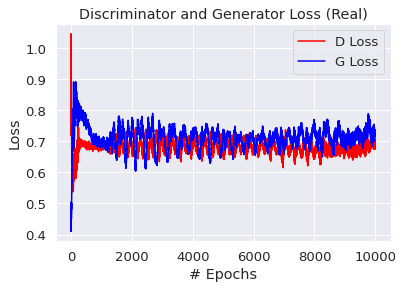

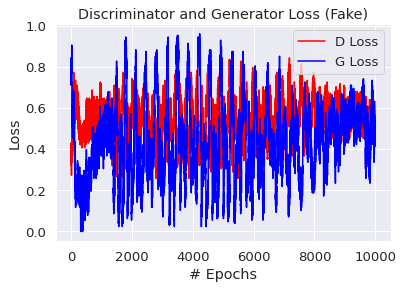

In [9]:
plot_loss(e, d[:,0], g[:,0], 'R')
plot_loss(e, d[:,1], g[:,1], 'F')

In [10]:
print("Final Discriminator Loss:", d[9999])
print("Final Generator Loss:", g[9999])

[0.69436324 0.453125  ]
[0.72133714 0.5390625 ]
